In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mat4py
import stumpy
import matplotlib.pylab as pl
#import ot 
import tensorflow as tf
import keras 
from keras.layers import Dense, Dropout
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from vmdpy import VMD 

import time
from matplotlib.patches import Rectangle


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/wang_to/opt/anaconda3/envs/end2end/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/wang_to/opt/anaconda3/envs/end2end/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/wang_to/opt/anaconda3/envs/end2end/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type,

In [2]:
data = pd.read_csv("ts_cat_555.csv").transpose()


In [3]:
ts_cat_555 = data.iloc[1,:]

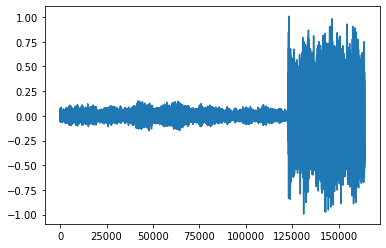

In [6]:
plt.plot(ts_cat_555)

In [4]:
alpha = 2000
tau = 0.
k = 5
DC = 0
init = 1
tol = 1e-7
u, u_hat, omega = VMD(ts_cat_555, alpha, tau, k, DC, init, tol)



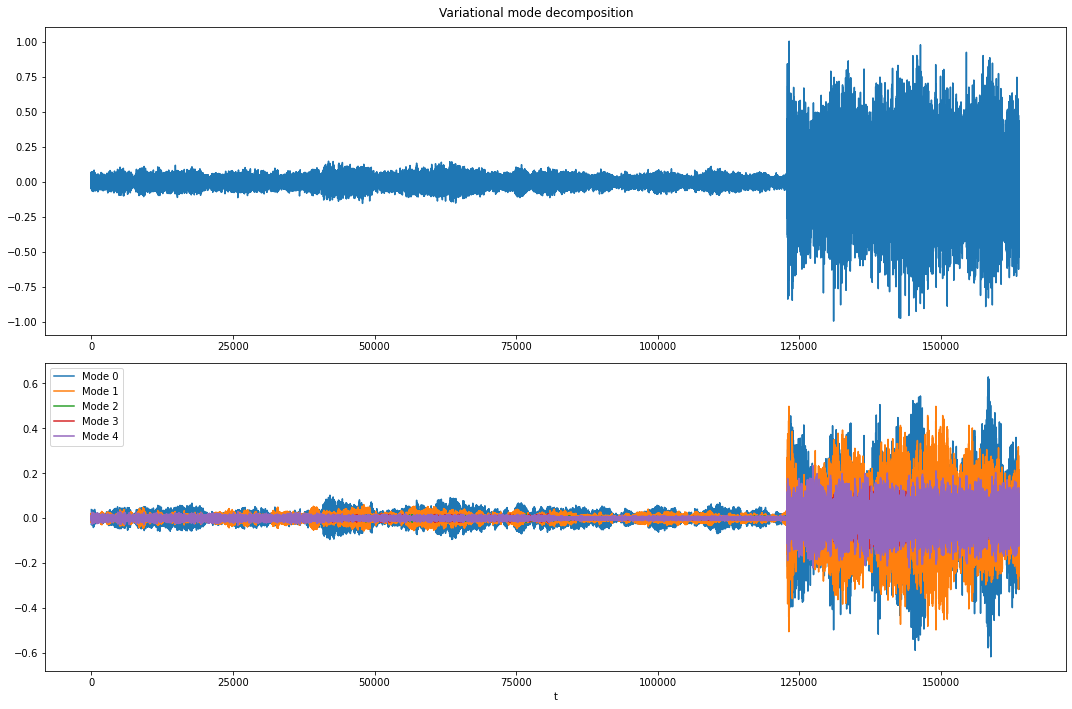

In [8]:
fig, axs = plt.subplots(2,1)
fig.set_size_inches(15,10)
fig.suptitle("Variational mode decomposition")
axs[0].plot(ts_cat_555.values)
axs[1].plot(u.T)
axs[1].set_xlabel("t")
axs[1].legend(["Mode %d"%m_i for m_i in range(u.shape[0])])
plt.tight_layout()

# TO BE DONE AND DIRECTIONS
- Use Variational Mode Decomposition and feature engineering to neural network our way to success
- Somehow combine this with matrix profiles? How to combine together the information from both?
- Wasserstein barycentre different sensors together to reduce noise...just see what happens

In [9]:
import sys
sys.path.append("/Users/wang_to/DBA")

import DBA

In [6]:
data_dict = np.load('data_dict.npy',allow_pickle='TRUE').item()


In [11]:
cases = [['L00','D00','V08'],   ['L1C','DB0','V08'],     ['L1C','DBB','V08'],      ['L13','DBB','V08']]
col_names = [["damage_location"], ["damage_level"], ["voltage_level"]]

def boolean_rows(a):
    return(a[0] & a[1] & a[2])

num_sensors = 3
ts_cat = []
for n in range(1,num_sensors+1):
    sens = data_dict["Sensor"+str(n)] 

    L00_D = [] #initialise lists for indicators, rows, then data
    data_L00_D = []
    ind_D = []
    num_samples = 1 # number of segments you wish to extract from each type of data

    for i in range(len(cases)): #loop over the different cases and append them into one time series
        ind_D.append(sens[col_names]==cases[i]) # turn the indicators into a single T/F and find corresponding rows
        L00_D.append(sens[ind_D[i].apply(boolean_rows, axis=1)])
        data = L00_D[i].iloc[0:num_samples, :-4]
        data_L00_D.append(data)

    ts_pre_cat = []
    for j in range(len(cases)):
        temp_data = []
        for i in range(num_samples):
            temp_data.append(data_L00_D[j].iloc[i,:])
        ts_pre_cat.append(pd.concat(temp_data))
    ts_cat.append(pd.concat(ts_pre_cat))



In [12]:
np.shape(ts_cat)

(3, 32768)

In [13]:
length = 4000
ts_cat_log_array = np.array([np.log(np.abs(np.fft.fft(ts_cat[i].to_numpy()))[0:length] )  ])
ts_cat_array = np.array([ts_cat[i].to_numpy()[0:length] for i in range(len(ts_cat))]) # just concatenate the first 1000 of each sensor together to get a conglomerate "healthy" DBA
# note: if you try to do this for all 8192 points and more than 3 sensors, it takes a very long time to perform
print(np.shape(ts_cat_array[0]))
print(np.shape(ts_cat_log_array[0]))

(4000,)
(4000,)


In [14]:
#concat_DBA = DBA.performDBA(ts_cat_array)
concat_log_DBA = pd.Series(DBA.performDBA(ts_cat_log_array)).rolling(window=30).mean().dropna()

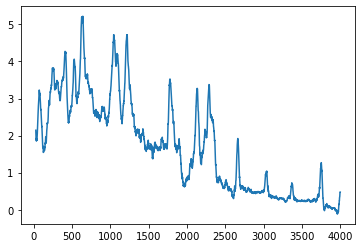

In [15]:
plt.plot(pd.Series(concat_log_DBA))

In [16]:
plt.plot(pd.Series(concat_DBA).rolling(window=30).mean())

NameError: name 'concat_DBA' is not defined

In [ ]:
mp_log = stumpy.stump(concat_log_DBA, m=250)

In [ ]:
mp_log

array([[8.672307642300517, 2051, -1, 2051],
       [8.701714697282105, 2052, -1, 2052],
       [8.743179928008404, 2053, -1, 2053],
       ...,
       [6.006270535962943, 3351, 3351, -1],
       [6.105699365023336, 3352, 3352, -1],
       [6.193888347498016, 3353, 3353, -1]], dtype=object)

NameError: name 'mp_log' is not defined

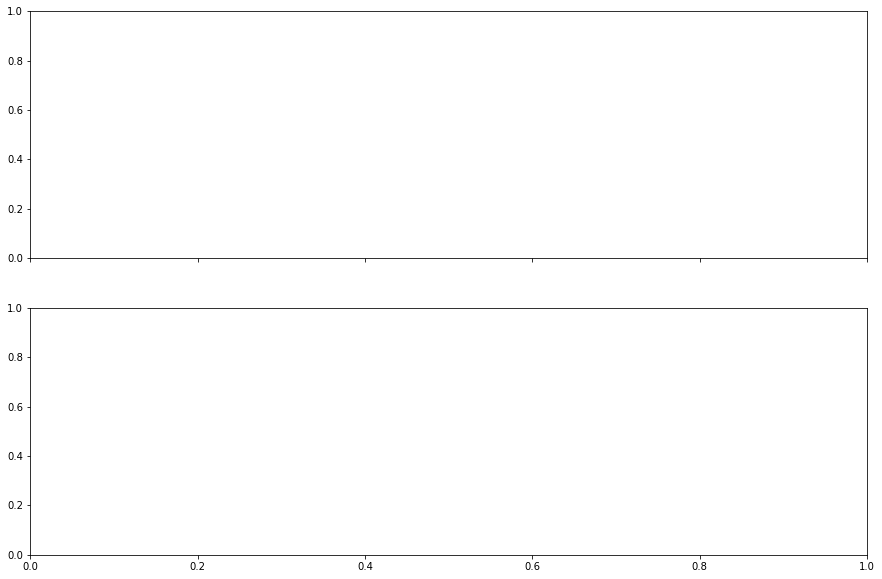

In [ ]:
fig, axs = plt.subplots(2,1,sharex=True)
fig.set_size_inches(15,10)

mp_idx = np.argsort(mp_log[0:, 0])[0] #take the 0th columns first element
nearest_neighbour_idx = mp_log[mp_idx, 1]

# discord 
discord_idx = np.argsort(mp_log[:, 0])[-1] #maximum distance 
discords = np.argsort(mp_log[:,0])[-50:]
discord_dist = mp_log[discord_idx, 0] #maximum distance
discord2_idx = mp_log[discord_idx, 1] #nearest neighbour
discord2_dist = mp_log[discord2_idx, 0]

for id_x, data in enumerate([mp_log[:,0], concat_log_DBA.values]):
    axs[id_x].plot(data)
    axs[id_x].set_xlabel("Time / ")
    axs[id_x].axvline(x=mp_idx, color="g")
    axs[id_x].axvline(x=nearest_neighbour_idx, color="g") #nearest neighbours (motif)
    for id_disc in discords:
        axs[id_x].axvline(x=id_disc, color="red")

# look for regime changes and nearest neighbours 

# Not too sure about the matrix profile approach...

# Using Variational Mode Decomposition For Feature Extraction
Along with Wasserstein Barycentre for data collection from multiple sensors.

In [ ]:
data_dict["Sensor2"]

,Xt_0,Xt_1,Xt_2,Xt_3,Xt_4,Xt_5,Xt_6,Xt_7,Xt_8,Xt_9,...,Xt_8186,Xt_8187,Xt_8188,Xt_8189,Xt_8190,Xt_8191,y_labels,damage_location,damage_level,voltage_level
0,0.373510,0.128960,0.139370,0.21629,0.242790,0.126130,0.235350,0.435830,0.18439,-0.011491,...,0.327280,0.276850,0.017979,0.356070,0.180200,0.125860,0,L00,D00,V02
1,0.253330,-0.067727,-0.107880,0.15032,-0.087058,-0.079488,-0.098819,-0.069349,-0.13221,-0.191280,...,0.072323,0.106790,-0.055290,-0.072864,-0.143290,-0.286860,0,L00,D00,V02
2,0.279420,0.331470,0.361610,0.47111,0.433530,0.542620,0.290910,0.174120,0.47246,0.162760,...,0.497070,0.608730,0.308890,0.300380,-0.010815,-0.016628,0,L00,D00,V02
3,-0.246300,-0.108550,0.014329,-0.24644,-0.137620,-0.024874,0.015546,-0.032985,-0.14911,0.048936,...,-0.340660,0.134370,0.245630,-0.244550,0.101520,0.309300,0,L00,D00,V02
4,0.236160,0.130050,0.252930,0.33160,0.249950,-0.027577,-0.016628,0.097332,-0.27645,-0.355940,...,-0.097872,-0.080434,0.064888,-0.130860,-0.041501,0.208450,0,L00,D00,V02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,0.449210,0.263470,0.220750,0.17966,0.163170,0.049071,-0.243330,-0.308350,0.12802,-0.300380,...,-0.095710,-0.030822,-0.195880,-0.452050,-0.152350,0.012437,1,L3A,DBB,V08
266,-0.033661,-0.310920,-0.344180,-0.21264,-0.108820,-0.226300,-0.693490,-0.412710,-0.13370,-0.252660,...,0.158300,0.135990,0.036499,0.147350,0.015816,0.196830,1,L3A,DBB,V08
267,-0.142890,-0.093952,-0.416900,-0.13437,0.080434,-0.110040,-0.050694,0.206970,0.30714,0.246300,...,0.034877,0.449210,0.120720,0.055966,0.253060,0.074215,1,L3A,DBB,V08
268,-0.097061,-0.205750,-0.450430,-0.51721,-0.357960,-0.080434,-0.410010,-0.431910,-0.29781,-0.146670,...,0.155460,0.231700,0.344850,0.049883,-0.083678,-0.035283,1,L3A,DBB,V08


In [ ]:
num_samples = 1
num_sensors = 2 # just take from first 5 sensors

DBA_sensor = []
for samp_n in range(num_samples):
    pre_DBA = []
    for sens_n in range(1, num_sensors+1):
        sens = data_dict["Sensor"+str(sens_n)]
        pre_DBA.append(sens.iloc[samp_n,:-4])
    pre_DBA = np.array([arr.to_numpy() for arr in pre_DBA])
    DBA_sensor.append(DBA.performDBA(pre_DBA))

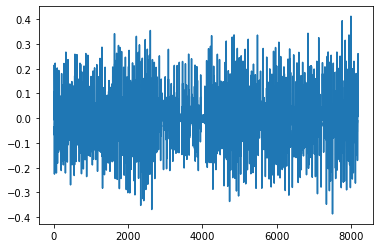

In [ ]:
plt.plot(DBA_sensor[0])

In [8]:
sys.path.append("/Users/wang_to/Documents/University/Anomaly_detection/anomalies/carvalho-etal-2019")
from main_feats import featExtract


# IDEAS FOR 7/12  
- test extract features after DBA is done
- This takes way too long - do dimensionality reduction? (log fft, then feature extract from this compressed data)
- Get the research code feature creator working, then try to apply LDA, SVM, forest, ...

## The features that are computed by featExtract are: 
- Spectral power (pow)
- Spectral entropy (ent)
- Spectral centroid (cent)
- AM, FM bandwidths (AM, BM)
- Hjorth Mobility (Hmob)
- Hjorth Complexity (Hcomp)
- Skew, Kurtosis

In [9]:
sens1=data_dict["Sensor1"]
sens1["voltage_num"] = [int(x[0][-1]) for x in sens1["voltage_level"].to_numpy()] # in fact, .to_numpy will return a list of lists, so to slice the string, you need to index one more time 

healthy_s1 = sens1[(sens1["y_labels"]==0).squeeze(axis=1)]
damaged_s1 = sens1[(sens1["y_labels"]==1).squeeze(axis=1)]

data_healthy_s1 = healthy_s1.iloc[:,0:8192]
data_damaged_s1 = damaged_s1.iloc[:,0:8192]

def featExt(data): # for 1600 parameter
    return(featExtract(data, Fs=1600)) 
features_healthy_s1 = data_healthy_s1.apply(featExt,axis=1)
features_damaged_s1 = data_damaged_s1.apply(featExt, axis=1)

healthy_input = pd.concat([features_healthy_s1, healthy_s1["voltage_num"]], axis=1)
damaged_input = pd.concat([features_damaged_s1, damaged_s1["voltage_num"]], axis=1)

def unpack_tuple(feats):
    '''
    Input: sens1 is a panda series of outputs from applying featExtract to another series
    Output: panda dataframe with the correct column names and output'''
    # idea: loop through series, unpack tuple, create columns
    _, col_names = feats.iloc[0]
    df = pd.DataFrame(columns=col_names)
    feats_first = feats.first_valid_index()
    for idx, tuples in enumerate(feats):
        data, _ = tuples
        df.loc[idx+feats_first] = data
    return df

def log_cols(df, cols):
    for col in cols:
        df[col] = df[col].apply(lambda a: np.log(a))

healthy_input = unpack_tuple(features_healthy_s1)
damaged_input = unpack_tuple(features_damaged_s1)

# logify first two columns

healthy_input["AM"] = healthy_input["AM"].apply(lambda a: np.log(a))
healthy_input["BM"] = healthy_input["BM"].apply(lambda a: np.log(a))
healthy_input["pow"] = healthy_input["pow"].apply(lambda a: np.log(a))

damaged_input["AM"] = damaged_input["AM"].apply(lambda a: np.log(a))
damaged_input["BM"] = damaged_input["BM"].apply(lambda a: np.log(a))
damaged_input["pow"] = damaged_input["pow"].apply(lambda a: np.log(a))

healthy_input = pd.concat([healthy_input, healthy_s1["voltage_num"]], axis=1)
damaged_input = pd.concat([damaged_input, damaged_s1["voltage_num"]], axis=1)

total_input = pd.concat([pd.concat([healthy_input, damaged_input], axis=0), sens1["y_labels"]], axis=1)
total_input.columns = ["AM", "BM", "ent", "pow", "Cent", "pk", "freq", "skew", "kurt", "Hmob", "Hcomp", "voltage_num", "y_labels"]


In [ ]:
total_input

,AM,BM,ent,pow,Cent,pk,freq,skew,kurt,Hmob,Hcomp,voltage_num,y_labels
0,14.770663,18.219263,5.434050,-25.682845,179.110836,0.000046,32.8125,0.019741,-0.237593,0.920375,1.908908,2,0
1,14.502801,18.051682,5.090054,-25.073920,155.171936,0.000052,32.8125,-0.043976,0.184552,0.781151,2.214397,2,0
2,14.127033,17.728356,4.110170,-23.553807,105.560880,0.000129,32.8125,-0.021230,-0.381595,0.627150,2.761173,2,0
3,14.362882,17.899392,4.344860,-23.908486,128.602243,0.000110,59.3750,0.016864,-0.363946,0.728563,2.390156,2,0
4,14.230340,17.890359,4.251189,-23.522809,119.429703,0.000145,59.3750,-0.041615,-0.125535,0.692294,2.495474,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,11.830651,17.860998,4.165823,-14.030360,118.198013,0.014225,59.3750,0.033094,0.176223,0.701665,2.494975,8,1
266,12.224803,18.085379,4.841938,-15.399976,154.499250,0.007185,59.3750,-0.021291,-0.225112,0.851233,2.076801,8,1
267,12.125614,18.144779,4.760425,-15.024886,171.456256,0.007544,59.3750,0.044560,0.170456,0.869137,2.046446,8,1
268,11.821424,17.821305,4.304614,-14.232357,112.448773,0.010165,59.3750,-0.038062,0.108367,0.688726,2.550560,8,1


## MLP, SVM (linear and RBF), KNN
- NO VMD CASE 

# MLP

In [10]:
target = ["y_labels"]
features = [item for item in total_input.columns if item not in target] 
# create train and test set
train_X, test_X, train_Y, test_Y = train_test_split(total_input[features], total_input[target], train_size=0.8)

In [11]:
print(train_X.head())
print(train_Y.head())
print(test_X.head())
print(test_Y.head())

            AM         BM       ent        pow        Cent        pk     freq  \
20   12.240481  17.996105  4.338917 -15.165145  143.675415  0.008810  59.3750   
128  12.348727  17.935594  4.481664 -15.898851  139.539949  0.005656  32.8125   
148  12.143349  18.048028  4.500123 -14.801775  151.219545  0.009536  59.3750   
172  12.659552  17.939041  5.259983 -17.589352  138.580455  0.002640  29.6875   
132  11.686294  17.840941  4.039167 -13.598747  115.842593  0.018796  59.3750   

         skew      kurt      Hmob     Hcomp  voltage_num  
20   0.013162 -0.075322  0.794213  2.234338            2  
128  0.059869 -0.201934  0.766177  2.316454            8  
148 -0.030124 -0.257194  0.825020  2.153232            8  
172 -0.011782 -0.140790  0.762227  2.260563            5  
132  0.031674 -0.263935  0.653643  2.643323            8  
     y_labels
20          0
128         0
148         0
172         1
132         0
            AM         BM       ent        pow        Cent        pk     fr

In [12]:
class linear_nn(tf.keras.Model):
    def __init__(self, hidden, training=False):
        super(linear_nn, self).__init__()
        self.dense1 = Dense(hidden, activation="relu", kernel_regularizer=tf.keras.regularizers.l1(0.01), 
        activity_regularizer=tf.keras.regularizers.l2(0.01))
        self.dense2 = Dense(hidden, activation="relu", kernel_regularizer=tf.keras.regularizers.l1(0.01), 
        activity_regularizer=tf.keras.regularizers.l2(0.01))
        self.out = Dense(1, activation = "sigmoid")
        self.dropout = Dropout(rate=0.5)
    
    def call(self, inputs, training=False):
        x = self.dense1(inputs)
        if training:
            x = self.dropout(x, training=training)
        x = self.dense2(x)
        return self.out(x)
    
model = linear_nn(200, training=True)
model.compile(loss = "binary_crossentropy", optimizer="adam", metrics=["accuracy"]) #tf.keras.metrics.AUC(num_thresholds=300, curve="ROC")])
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="/Users/wang_to/Documents/University/Anomaly_detection/anomalies/logs")
history = model.fit(train_X.values, train_Y.values, validation_data = (test_X.values, test_Y.values), epochs = 2000, verbose=0)

results_train = model.evaluate(train_X.values, train_Y.values)
results_test = model.evaluate(test_X.values, test_Y.values)
predictions = model.predict(test_X.values)
#print(f"Validation accuracies: train - {train_acc:.3f}, test - {test_acc:.3f}")
#print(f"F1 score = {f1_score(test_Y.values, predictions)}")



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2022-01-06 17:47:49.877698: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA


KeyboardInterrupt: 

[0.057328334285153285, 0.9814815]
[0.5530619003154613, 0.8148148]
auc score is 0.9.


Text(0, 0.5, 'tpr')

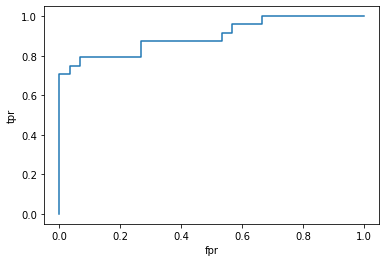

In [ ]:
print(results_train)
print(results_test)
score = roc_auc_score(test_Y, predictions)
print(f"auc score is {score}.")
fpr, tpr, thresholds = roc_curve(test_Y, predictions)
plt.plot(fpr, tpr)
plt.xlabel("fpr")
plt.ylabel("tpr")

# SVM
## Linear then RBF

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

linear_svm = make_pipeline(StandardScaler(), svm.SVC(C=1000, kernel="linear", gamma = "auto"))
linear_svm = linear_svm.fit(train_X, train_Y)
test_predictions = linear_svm.predict(test_X)

real_Y = [x[0] for x in test_Y.values]

accuracy = np.sum(1-np.abs(test_predictions - real_Y)) / len(test_Y.index)
print(f"Linear Accuracy = {accuracy}")



/Users/wang_to/opt/anaconda3/envs/end2end/lib/python3.7/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear Accuracy = 0.8888888888888888


In [ ]:
rbf_svm = make_pipeline(StandardScaler(), svm.SVC(C=10, kernel="rbf", gamma="auto"))
rbf_svm = rbf_svm.fit(train_X, train_Y)
test_predictions = rbf_svm.predict(test_X)

real_Y = [x[0] for x in test_Y.values]

accuracy = np.sum(1-np.abs(test_predictions - real_Y)) / len(test_Y.index)
print(f"RBF accuracy = {accuracy}")

RBF accuracy = 0.6666666666666666


/Users/wang_to/opt/anaconda3/envs/end2end/lib/python3.7/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# One class SVM

# Linear Discriminant Analysis 
- This assumes a normal distribution in the feature space, and I haven't checked whether this assumption holds, but can see if it works anyway?

# Feature Extraction, This Time From VMD, Like I Wanted To Do From The Start

In [ ]:
# let's do the same thing but with the variational mode decomposition like I wanted to 
sens1.iloc[:,:-5]

,Xt_0,Xt_1,Xt_2,Xt_3,Xt_4,Xt_5,Xt_6,Xt_7,Xt_8,Xt_9,...,Xt_8182,Xt_8183,Xt_8184,Xt_8185,Xt_8186,Xt_8187,Xt_8188,Xt_8189,Xt_8190,Xt_8191
0,0.015912,0.034565,0.009650,0.018976,0.007931,0.027672,0.022788,0.014636,0.016848,0.007080,...,0.026957,0.027910,0.027553,0.035330,0.029748,0.021511,0.049660,-0.003863,0.035092,0.039466
1,-0.016916,0.004459,0.005973,-0.021001,0.007846,-0.008424,-0.012900,-0.004459,-0.014006,-0.017767,...,0.014330,0.023349,0.009769,0.009650,0.011096,-0.003063,0.008918,-0.015266,-0.020797,-0.012866
2,0.038836,0.038173,0.030480,0.033373,0.060467,0.016491,0.033305,0.039023,0.005940,0.031246,...,0.032982,0.036539,0.021443,0.042785,0.036726,0.041491,0.052655,0.003029,0.010688,0.004152
3,0.001549,-0.020507,-0.023281,-0.011470,-0.023128,-0.013649,-0.002927,-0.021971,-0.003591,-0.000987,...,-0.023247,-0.002417,-0.016712,-0.014840,0.008050,-0.004102,-0.018040,0.026192,0.002910,0.003846
4,0.012764,0.014755,0.026294,0.015300,0.004493,0.007284,0.000579,-0.018959,-0.007658,-0.040045,...,-0.012832,-0.010977,-0.015419,-0.014125,-0.005276,0.004816,-0.011777,0.008288,-0.009054,0.024881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,0.161270,0.318900,0.262800,0.016492,0.259690,-0.067862,-0.098819,0.036770,-0.262660,-0.161270,...,0.149380,-0.172900,0.083543,-0.172630,0.025279,0.052992,-0.182770,-0.153160,-0.126940,-0.013248
266,-0.122610,-0.046097,-0.191960,-0.021089,-0.050964,-0.279290,-0.143700,-0.332550,-0.164380,0.047720,...,0.350660,-0.002433,0.224540,0.270910,-0.129230,0.196690,0.207910,-0.167760,0.307000,-0.093006
267,0.191690,-0.179790,0.096385,0.050018,0.077054,0.202370,0.115180,0.170740,0.302000,0.385680,...,-0.191420,0.399330,0.053532,0.028524,0.518700,-0.045286,0.190340,0.453670,-0.190880,0.316060
268,-0.340660,-0.090032,-0.384460,-0.381080,-0.109500,-0.296590,-0.268340,-0.148300,-0.322680,-0.021764,...,0.198850,0.501660,0.223190,0.265630,0.454890,0.195470,0.147210,0.243460,-0.021900,0.120450


In [ ]:
alpha = 2000
tau = 0.
k = 5
DC = 0
init = 1
tol = 1e-7




In [ ]:
def vmd_aux(ts):
    return VMD(ts, alpha, tau, k, DC, init, tol)

In [ ]:
feat_series = sens1.iloc[:,:-5].apply(vmd_aux, axis = 1)

mode_list = [u for u, _, _ in feat_series]
np.shape(mode_list[0])

modes = []
for i in range(k):
    modes.append(np.array([u[i] for u in mode_list])) #ith element in list is 270-array of ith variational mode 

feat_modes = []
for i in range(k):
    feat_modes.append(pd.DataFrame(modes[0]).apply(featExt, axis=1))

modes_input = []
for feats in feat_modes:
    modes_input.append(unpack_tuple(feats))

for modes in modes_input:
    log_cols(modes, ["AM", "BM", "pow"])

In [ ]:
feat_modes # feat_modes[i][j] contains the ith mode's features of the jth time series (out of 270)

[0      ([218865.3098506308, 23275080.69432679, 3.3012...
 1      ([236733.90067207516, 25948507.484468576, 3.31...
 2      ([75142.68055330993, 22248007.447111797, 2.089...
 3      ([130553.0830252905, 21556753.12838887, 2.3683...
 4      ([150455.9878893234, 20870335.076863486, 2.894...
                              ...                        
 265    ([8750.18579693851, 20861742.634828947, 2.4124...
 266    ([14657.334305118082, 19061853.145679384, 3.13...
 267    ([10492.222223653966, 20658613.37666149, 2.635...
 268    ([6750.81423309769, 20660675.2327387, 2.551095...
 269    ([6976.409715230556, 21182233.446883112, 2.339...
 Length: 270, dtype: object,
 0      ([218865.3098506308, 23275080.69432679, 3.3012...
 1      ([236733.90067207516, 25948507.484468576, 3.31...
 2      ([75142.68055330993, 22248007.447111797, 2.089...
 3      ([130553.0830252905, 21556753.12838887, 2.3683...
 4      ([150455.9878893234, 20870335.076863486, 2.894...
                              ...          

In [ ]:
modes_input # modes_input now consists of 5 270xnum_features-sized dataframes containing features for all 270 time series
# the ith list element contains the ith variational modes features for each time series

[            AM         BM       ent        pow       Cent        pk     freq  \
 0    12.296212  16.962894  3.301289 -25.930087  33.265033  0.000046  32.8125   
 1    12.374692  17.071625  3.317201 -25.702545  36.832666  0.000050  32.8125   
 2    11.227144  16.917763  2.089505 -23.978686  31.673829  0.000128  32.8125   
 3    11.779535  16.886200  2.368368 -25.118365  30.854637  0.000071  32.8125   
 4    11.921426  16.853839  2.894536 -25.567727  29.825662  0.000055  32.8125   
 ..         ...        ...       ...        ...        ...       ...      ...   
 265   9.076830  16.853428  2.412474 -15.163444  29.868456  0.008940  31.2500   
 266   9.592696  16.763200  3.130440 -16.981197  27.531905  0.003065  31.2500   
 267   9.258390  16.843643  2.635011 -15.822454  29.466932  0.005990  32.8125   
 268   8.817418  16.843743  2.551095 -14.835980  29.484514  0.009630  31.2500   
 269   8.850290  16.868673  2.339298 -14.942086  30.202157  0.009746  31.2500   
 
          skew      kurt  

In [ ]:
modes_total_input = [pd.concat([feats, sens1["voltage_num"]])]

In [ ]:
# one way: average the predictions among all 5 networks in naive way 
# second way: generate new features for each vmd
# data processing process
# to be done: complete processing variational mode data. finish end2end. read papers.

In [ ]:
# now: define 5 MLP models and train, then predict
# to be done: complete 
model_list = []
pred_list = []
acc_train_list = []
acc_test_list = []

for i in range(k): # k is number of variational modes
    model_list.append(linear_nn(200))

for model in model_list:
    model.compile(loss = "binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    history=model.fit(train_X.values, train_Y.values, validation_data = (test_X.values, test_Y.values), epochs=2000, verbose=0)
    results_train = model.evaluate(train_X.values, train_Y.values)
    results_test = model.evaluate(test_X.values, test_Y.values)
    predictions = model.predict(test_X.values)

    pred_list.append(predictions)
    acc_test_list.append(results_test)
    acc_train_list.append(results_train)
    

TypeError: __init__() got an unexpected keyword argument 'n'